### Libraries Import

In [ ]:
import torch
from dataset import PromptDataset
from model import ModelWrapper
from feature_extraction import get_prediction_trajectory
from anomaly_detection import AnomalyDetector
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load and Split Dataset:

In [ ]:
# Load dataset
print("Loading dataset...")
dataset = PromptDataset.from_huggingface()
train_data, test_data = dataset.split()

### Detect Prompt Injections using Logit Lens

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Processing training prompts: 100%|██████████| 176/176 [27:09<00:00,  9.26s/it] 


Evaluating...
Results: {'iforest_auroc': 0.42768595041322316, 'lof_auroc': 0.36311983471074377, 'srm_auroc': 0.6394628099173554}


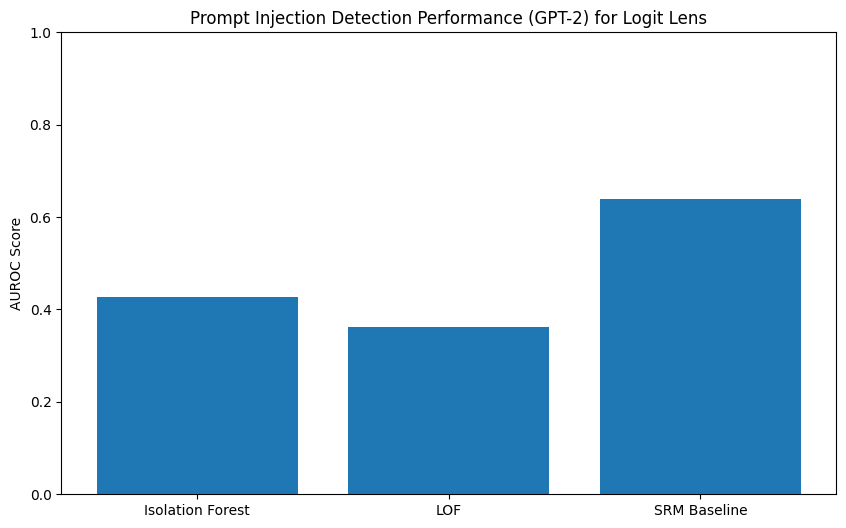

In [ ]:
# Load model and lens
model_wrapper = ModelWrapper('logit_lens')
model = model_wrapper.get_model()
tokenizer = model_wrapper.get_tokenizer()
lens = model_wrapper.get_lens()

# Extract prediction trajectories for training (this can be batched or parallelized as needed)
train_trajectories = []
for prompt in tqdm(train_data.normal_prompts, desc="Processing training prompts"):
    traj = get_prediction_trajectory(prompt,  model, tokenizer, lens)
    if traj is not None:
        train_trajectories.append(traj)

# Initialize anomaly detector
detector = AnomalyDetector()

# Train anomaly detectors
detector.train_detectors(train_trajectories)

# Evaluate on test data
print("Evaluating...")
X, y = [], []
for prompt in test_data.normal_prompts + test_data.adversarial_prompts:
    traj = get_prediction_trajectory(prompt, model, tokenizer, lens)
    if traj is not None:
        X.append(traj)
        y.append(0 if prompt in test_data.normal_prompts else 1)

X = np.array(X)
y = np.array(y)
results = detector.evaluate(X, y)
print("Results:", results)


# Plot results
plt.figure(figsize=(10, 6))
plt.bar(['Isolation Forest', 'LOF', 'SRM Baseline'],

       [results['iforest_auroc'], results['lof_auroc'], results['srm_auroc']])
plt.ylim(0, 1)
plt.title('Prompt Injection Detection Performance (GPT-2) for Logit Lens')
plt.ylabel('AUROC Score')
plt.show()

### Detect Prompt Injections using Tuned Lens

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

params.pt:   0%|          | 0.00/236M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/tuned_lens/nn/lenses.py:277: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = th.load(ckpt_path, **th_load_kwargs)
Processing tr

Evaluating...
Results: {'iforest_auroc': 0.33832644628099173, 'lof_auroc': 0.4183884297520661, 'srm_auroc': 0.7014462809917354}


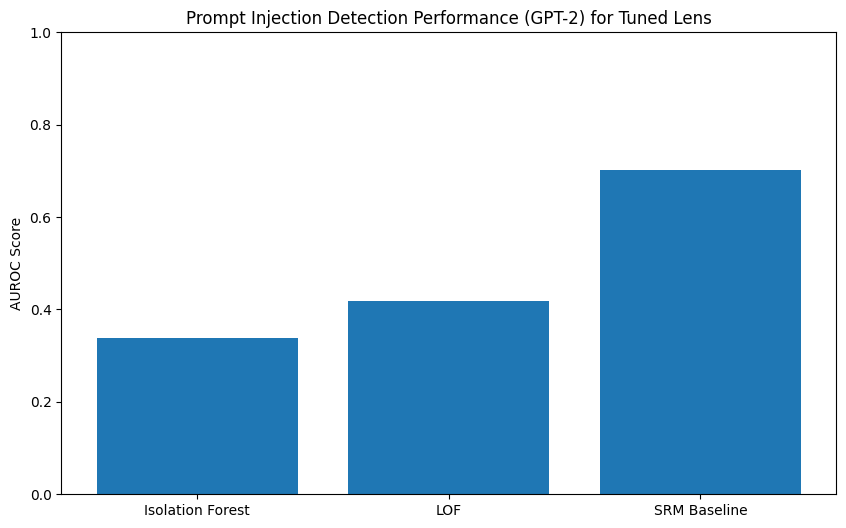

In [ ]:
# Load model and lens
model_wrapper = ModelWrapper()
model = model_wrapper.get_model()
tokenizer = model_wrapper.get_tokenizer()
lens = model_wrapper.get_lens()

# Extract prediction trajectories for training (this can be batched or parallelized as needed)
train_trajectories = []
for prompt in tqdm(train_data.normal_prompts, desc="Processing training prompts"):
    traj = get_prediction_trajectory(prompt,  model, tokenizer, lens)
    if traj is not None:
        train_trajectories.append(traj)

# Initialize anomaly detector
detector = AnomalyDetector()

# Train anomaly detectors
detector.train_detectors(train_trajectories)

# Evaluate on test data
print("Evaluating...")
X, y = [], []
for prompt in test_data.normal_prompts + test_data.adversarial_prompts:
    traj = get_prediction_trajectory(prompt, model, tokenizer, lens)
    if traj is not None:
        X.append(traj)
        y.append(0 if prompt in test_data.normal_prompts else 1)

X = np.array(X)
y = np.array(y)
results = detector.evaluate(X, y)
print("Results:", results)


# Plot results
plt.figure(figsize=(10, 6))
plt.bar(['Isolation Forest', 'LOF', 'SRM Baseline'],

       [results['iforest_auroc'], results['lof_auroc'], results['srm_auroc']])
plt.ylim(0, 1)
plt.title('Prompt Injection Detection Performance (GPT-2) for Tuned Lens')
plt.ylabel('AUROC Score')
plt.show()